In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import block_diag
from numpy.linalg import multi_dot
from scipy.linalg import sqrtm
from scipy.sparse import csgraph
import os

In [2]:
N_TRIAL = 30000
N_ARMS = 100
K = 3
N_FEATURE = 3
M = 33

In [3]:
Y_2 = np.genfromtxt(r'C:\Users\ARTY\Desktop\jupyter lab\case2\poly2_Y_all.csv',delimiter=',', skip_header=1)
W = np.genfromtxt(r'C:\Users\ARTY\Desktop\jupyter lab\case2\poly2_W.csv',delimiter=',', skip_header=1)

In [4]:
# Initialize q and C
# vec_q: q (Kp x 1)
np.random.seed(3) #3 #59
vec_q = np.array([np.random.rand() for _ in range(K * N_FEATURE)])
# vec_C: C (NK x 1)
np.random.seed(42)
vec_C = np.array([np.random.rand() for _ in range(N_ARMS * N_FEATURE)])

In [5]:
def plot_rewards(results):
    [plt.plot(x['c_payoff']/33, label="alpha: "+str(alpha)) for (alpha, x) in results.items()]
def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x['r_payoff'], oracle=oracle), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]

def make_regret(payoff, oracle):
    return np.cumsum(oracle - payoff)


In [6]:
# X transformation from a sparse matrix
def X_reshape(X, X_tr, t, K, n_arms, n_feature):  #
  for arm in range(1, n_arms):
    X_tr = np.concatenate((X_tr,np.kron(np.identity(n = K),X[arm].reshape(-1,1))), axis = 1)
  return X_tr

# convert to a sparse matrix
def X_to_X_m(X, t, arm_choice, n_arms, n_feature):
  X_m = np.copy(X[t])
  for arm in np.arange(n_arms): # N x p
    if arm not in arm_choice:
      X_m[arm] = np.zeros(shape=n_feature)
  return X_m

In [7]:
# Create the F matrix
def constructAdjMatrix(W, n, threshold): #m
    Adj_mat = np.zeros(shape = (n, n))
    for ui in range(n):
        for uj in range(n):
            Adj_mat[ui][uj] = W[ui][uj]
        # trim the graph
            for i in range(n):
                if W[ui][i] <= threshold:
                    Adj_mat[ui][i] = 0;
#         Adj_mat[ui] /= sum(Adj_mat[ui])
    return Adj_mat
def constructLaplacianMatrix(W, n, Gepsilon):
    G = W.copy()
    #Convert adjacency matrix of weighted graph to adjacency matrix of unweighted graph
    for i in range(n):
        for j in range(n):
            if G[i][j] > 0:
                G[i][j] = 1
    L = csgraph.laplacian(G, normed = False)
    I = np.identity(n = G.shape[0])
    GW = I + Gepsilon*L  # W is a double stochastic matrix
    return GW.T

In [8]:
# Create the F matrix
lda = 1
threshold = 0.5
test_adj = constructAdjMatrix(W, N_ARMS, threshold)
test_F = constructLaplacianMatrix(test_adj, N_ARMS, lda)
# F_kron = np.kron(test_F, np.identity(n=K))
FInv_Init = sqrtm(np.linalg.inv(np.kron(test_F, np.identity(n=K))))

In [9]:
#eta_1, eta_2, lambda = tuning param.
#alpha_q, alpha_c = exploration parameters for q and C
#X = feature matrix
#Y = true reward matrix
#F = the sum of the identity matrix (N x N) and the laplacian matrix E
#FInv = The inverse of the sqrt of the kronecker product between the F and the identity matrix (K x K)
#m = number of selected arms
#K = number of latent structures

def CoCoUCB(eta_1, eta_2, alpha_q, alpha_c, X, Y, init_q, init_c, m, K, FInv, X_to_X_m, X_reshape):
    print("CoCoUCB with eta_1:", eta_1, "eta_2:", eta_2, "alpha_q:", alpha_q, "alpha_c:", alpha_c)
    n_trial, n_arms, n_feature = X.shape
    #n_arms = N | n_trial = t | n_features = p | K

    # 1. Initialize objects
    # 1.1. Output objects                     
    arm_choice = np.empty(shape=(n_trial, m), dtype=int)
    r_payoff = np.empty(n_trial)   
    c_payoff = np.empty(n_trial) 
    p = np.empty(shape=(n_trial, n_arms)) 
    acc = np.empty(shape=(n_trial, n_arms))
    
    theta_lst = np.empty(shape=(n_trial, n_arms * n_feature))
    C_lst = np.empty(shape=(n_trial, n_arms * K))
    q_lst = np.empty(shape=(n_trial, K * n_feature))

    
    # 1.2. Intialize q and C_tilde
    q = np.empty(shape = (n_trial + 1, K * n_feature)) #Kp x 1
    C_tilde = np.empty(shape = (n_trial + 1, n_arms * K)) #NK x 1
    q[0] = init_q
    C_tilde[0] = init_c
    
    # 1.4. A, b, D, d
    A = eta_1 * np.identity(n = K * n_feature) #Kp x Kp
    b = np.zeros(shape=K * n_feature)          #Kp x 1
    D = eta_2 * np.identity(n = n_arms * K)    #NK x NK
    d = np.zeros(shape=n_arms * K)             #NK x 1
    inv_A = np.linalg.inv(A)
    inv_D = np.linalg.inv(D)
    
    # 2. Algorithm
    for t in np.arange(n_trial):
        for a in np.arange(n_arms):
            
          #x_tr for q case 
          X_temp = X_to_X_m(X, t, [a], n_arms, n_feature)    
          X_tr_init = np.kron(np.identity(n = K),X_temp[0].reshape(-1,1))
          X_tr = X_reshape(X_temp, X_tr_init, t, K, n_arms, n_feature) #Kp x NK 
          
          #x_tr for c case
          X_tilde = FInv.dot(X_to_X_m(X, t, [a], n_arms, n_feature).flatten()) #Np x 1
          q_block = (block_diag(*[q[t].reshape((K, n_feature)) for _ in np.arange(n_arms)])).T #Np x NK  
        
          #Calculate cb_q and cb_c
          #cb_q  
          X_q_a = X_tr.dot(FInv.dot(C_tilde[t]))
          cb_q = alpha_q * np.sqrt(X_q_a.T.dot(inv_A).dot(X_q_a))
        
          #cb_c
          X_c = q_block.T.dot(X_tilde)
          cb_c = alpha_c * np.sqrt((X_c).T.dot(inv_D).dot(X_c))
        
          #Predictions
          p[t, a] = (FInv.dot(C_tilde[t]).T).dot(X_tr.T).dot(q[t]) + cb_q + cb_c
          acc[t, a]   = p[t, a] - Y[t, a]
        # Choose m best arms
        chosen_arms = p[t].argsort()[-m:][::-1]
        for i in np.arange(m):
          arm_choice[t][i] = chosen_arms[i]
        
        #Update A, b, D, d for each selected arm
        for chosen_arm in arm_choice[t]:

          #X transformations
          #x_tr for q case
          X_tr_chosen_temp = X_to_X_m(X, t, [chosen_arm], n_arms, n_feature)
          X_tr_init_cs = np.kron(np.identity(n = K),X_tr_chosen_temp[0].reshape(-1,1))
          X_1_tr_chosen =  X_reshape(X_tr_chosen_temp, X_tr_init_cs, t, K, n_arms, n_feature)
            
          #x_tr for c case
          X_tilde_chosen = FInv.dot(X_to_X_m(X, t, [chosen_arm], n_arms, n_feature).flatten())
          q_block_chosen = (block_diag(*[q[t].reshape((K, n_feature)) for _ in np.arange(n_arms)])).T
            
          #Update  
          X_q = FInv.dot(C_tilde[t]).dot(X_1_tr_chosen.T)
          X_C_Tilde = q_block_chosen.T.dot(X_tilde_chosen)
          A = A + np.outer(X_q, X_q)
          b = b + Y[t, chosen_arm] * X_q
          D = D + np.outer(X_C_Tilde, X_C_Tilde)           
          d = d + Y[t, chosen_arm] * X_C_Tilde
        
        #inverse calculation
        inv_A = np.linalg.inv(A)
        inv_D = np.linalg.inv(D)
        q[t + 1] = inv_A.dot(b)
        C_tilde[t + 1] = inv_D.dot(d)
        
        #just for recording data
        q_lst[t] = q[t + 1]
        C_lst[t] = C_tilde[t + 1]
        theta_lst[t] = ((q[t + 1].reshape(n_feature, K)).dot(C_tilde[t + 1].reshape(K,n_arms)).flatten())
                
        # Cumulative rewards
        if t == 0:
            c_payoff[t] = np.sum([Y[t, choice] for choice in arm_choice[t]])
        else:
            c_payoff[t]   = c_payoff[t-1] + np.sum([Y[t, choice] for choice in arm_choice[t]])
        r_payoff[t]   = np.sum([Y[t, choice] for choice in arm_choice[t]])
        
        if (t+1) % 1000 == 0:
            print('TRIAL:',t,'DONE', '| arm selected:', chosen_arms)
    return dict(theta_lst=theta_lst, q_lst=q_lst, C_lst=C_lst, q = q, C_tilde = C_tilde, p = p, arm_choice = arm_choice, r_payoff = r_payoff, c_payoff = c_payoff, acc=acc)

In [10]:
# Create X_i = [1, t, t^2]
X_2_lst = []
for T in np.arange(N_TRIAL):
  X_2t_lst = []
  for arm in np.arange(N_ARMS):
    temp = []
    temp.append(1)
    temp.append(0.001*(T+1))
    temp.append((0.001*(T+1))**2)
    X_2t_lst.append(np.array(temp))
  X_2_lst.append(np.array(X_2t_lst))
X_2 = np.array(X_2_lst)

In [11]:
alpha_to_test = [4]
results_dict = {alpha: CoCoUCB(eta_1 = 0.3, eta_2 = 0.1, alpha_q = 4, alpha_c = alpha, X=X_2, Y=Y_2.T, init_q=vec_q, init_c=vec_C,m=M, K = K, FInv=FInv_Init, X_to_X_m=X_to_X_m, X_reshape=X_reshape)\
                for alpha in alpha_to_test}

CoCoUCB with eta_1: 0.3 eta_2: 0.1 alpha_q: 4 alpha_c: 4
TRIAL: 999 DONE | arm selected: [82 91 90 86 75 70 72 96 92 67 79 77 88 69 87 83 73 85 68 78 95 99 76 74
 71 98 84 47 57 97 80 89 81]
TRIAL: 1999 DONE | arm selected: [82 90 91 75 86 73 72 70 96 69 88 67 79 92 77 83 85 87 68 95 99 74 78 84
 71 76 80 98 81 97 89 57 50]
TRIAL: 2999 DONE | arm selected: [82 90 91 75 73 86 72 70 96 69 88 67 79 85 92 83 95 68 77 74 99 87 84 78
 80 81 71 98 76 97 89 57 94]
TRIAL: 3999 DONE | arm selected: [90 82 75 91 73 72 86 96 69 70 88 67 85 79 95 83 74 68 92 99 77 84 87 81
 80 78 71 98 89 97 76 93 57]
TRIAL: 4999 DONE | arm selected: [90 82 75 91 73 72 96 86 69 88 70 85 95 74 67 79 83 68 99 84 92 81 77 80
 87 78 71 98 89 97 93 76 51]
TRIAL: 5999 DONE | arm selected: [90 82 73 75 91 72 96 69 86 88 70 85 74 95 79 67 83 68 99 84 81 80 92 77
 87 78 71 89 98 97 93 51 76]
TRIAL: 6999 DONE | arm selected: [90 82 73 75 91 72 96 69 86 88 70 74 85 95 84 99 83 68 79 67 81 80 92 77
 87 71 89 78 93 98 97 51 76]

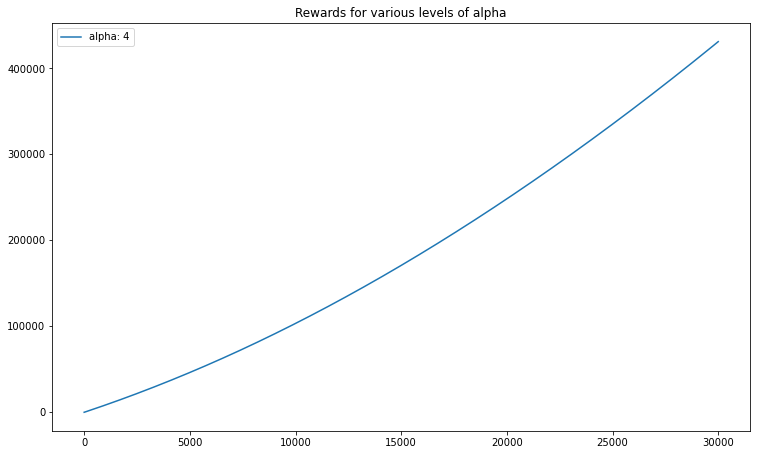

In [12]:
# Plot rewards
plt.figure(figsize=(12.5, 7.5))
plot_rewards(results_dict)
plt.legend()
plt.title("Rewards for various levels of alpha")
plt.show()

In [13]:
oracle_lst = []
true_choice = []
new_y = Y_2 #
for t in np.arange(N_TRIAL):
  # Find indices of M highest arms
  all_reward_t = [new_y.T[t, arm] for arm in np.arange(N_ARMS)]
  chosen_arms = np.array(all_reward_t).argsort()[-M:][::-1]

  # Sum of M highest rewards
  oracle_payoff_t = np.sum([new_y.T[t, choice] for choice in chosen_arms])
  # Append to the list
  oracle_lst.append(oracle_payoff_t)
  true_choice.append(chosen_arms)
  if (t+1) % 1000 == 0:
    print('TRIAL:',t,'DONE', '| arm selected:', chosen_arms)
oracle_case1 = np.array(oracle_lst)

TRIAL: 999 DONE | arm selected: [82 90 91 75 86 70 72 96 67 92 79 73 88 69 77 87 83 85 68 99 95 78 76 74
 71 98 84 80 81 97 47 57 89]
TRIAL: 1999 DONE | arm selected: [82 90 91 75 86 70 72 73 96 69 88 67 92 79 77 85 83 87 68 95 99 74 78 84
 71 76 80 98 81 97 89 57 47]
TRIAL: 2999 DONE | arm selected: [82 90 91 75 73 86 72 70 96 69 88 67 79 92 85 83 95 77 68 99 74 87 84 78
 80 81 71 98 76 97 89 57 94]
TRIAL: 3999 DONE | arm selected: [90 82 75 91 73 72 86 96 69 70 88 67 85 79 95 83 74 68 92 99 77 84 87 81
 80 78 71 98 89 97 76 93 57]
TRIAL: 4999 DONE | arm selected: [90 82 75 91 73 72 86 96 69 70 88 85 95 67 74 79 83 68 99 92 84 77 81 80
 87 78 71 98 89 97 93 76 57]
TRIAL: 5999 DONE | arm selected: [90 82 75 73 91 72 96 69 86 88 70 85 74 95 67 79 99 83 68 84 81 80 92 77
 87 78 71 89 98 97 93 76 51]
TRIAL: 6999 DONE | arm selected: [90 82 73 75 91 72 96 69 86 88 70 74 85 95 99 84 83 68 79 67 81 80 92 77
 87 71 89 78 93 98 97 76 51]
TRIAL: 7999 DONE | arm selected: [90 82 73 75 91 72 96 6

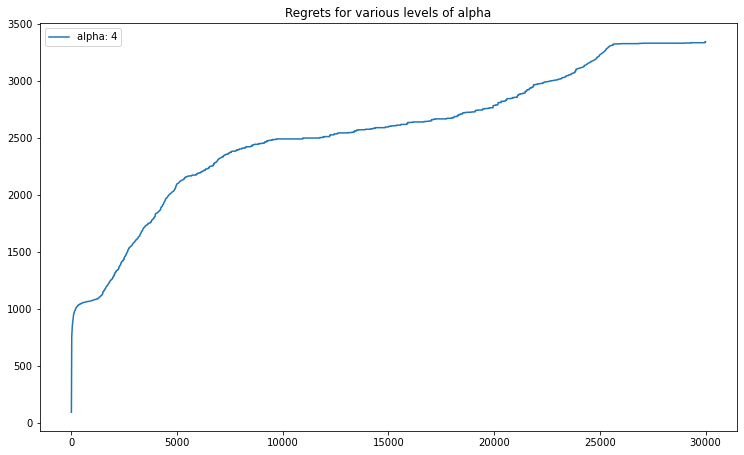

In [14]:
#regret
# Plot regrets
plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, oracle_case1)
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()

In [15]:
# reward data
# test_lst = [x['c_payoff'] for (alpha, x) in results_dict.items()]
# df = pd.DataFrame(test_lst[0]) #index 4 is for alpha = 10 
# df.to_csv('C2_COCOlda5_reward(new).csv', header=False)

In [18]:
# regret data
# test_lst = [make_regret(payoff=x['r_payoff'], oracle=oracle_case1) for (alpha, x) in results_dict.items()]
# df = pd.DataFrame(test_lst[0]) #index 4 is for alpha = 10 
# df.to_csv('C2_COCOlda_poly2.csv', header=False)